# Uploading Datasets and Models


In [ ]:
!pip3 install opendatasets --upgrade

In [ ]:
import opendatasets as od
import PIL
import glob
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tabulate

def mount_drive(fr = False):
    from google.colab import drive
    drive.mount("/content/drive/", force_remount = fr)
    
def fetch_rps(shuffle = False, train_test_split = True, random_state = 0, train_size = 0.8):
    
    rocklst, paperlst, scissorslst = glob.glob("drive/My Drive/DATA4380-project/rockpaperscissors/rock/*"), glob.glob("drive/My Drive/DATA4380-project/rockpaperscissors/paper/*"), glob.glob("drive/My Drive/DATA4380-project/rockpaperscissors/scissors/*")
    
    def form_array(arr):

        a = []
        arr = np.asarray(arr)
           
        for i in arr:
            zq = np.asarray(PIL.Image.open(i))
            a.append(zq)
        

        return np.array(a)/255.0

        ## Turning each list into a 4D array (n, 200, 300, 3) 
        ## which contains the RGB images as arrays.
        ## We can take each 3D array contained within the larger structure as an individual input.
        ## Our targets will be categorical based on the list that it came out of.

    rock, paper, scissors = form_array(rocklst), form_array(paperlst), form_array(scissorslst)
    
    labels = pd.get_dummies(pd.Series(np.array([1]*len(rock) + [2]*len(paper) + [3]*len(scissors)))).to_numpy() 
    #one-hot encoding all of the labels made up from a list
    
    images = np.concatenate((rock,paper,scissors), axis = 0)
    
    if(shuffle):
        images, labels = sklearn.utils.shuffle(images, labels, random_state = random_state)
    
    if(train_test_split):
        image_train, image_test, label_train, label_test = sklearn.model_selection.train_test_split(images, labels, random_state = random_state, train_size = train_size, shuffle = True)
        
        return image_train, label_train, image_test, label_test
    
    else:
        return images, labels
    
def fetch_nature():
    
    # Choose your image size
    # AlexNet
    IMAGE_SIZE = (227, 227)
    
    output = []

    class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
    index  = [0, 1, 2, 3, 4, 5]

    # Build a dictionary that maps the category to an index/integer

    class_names_label = dict(list((zip(class_names, index))))

    # Iterate through training and test sets
    def function1(dataset):
      
        images = []
        labels = []

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # This function specifically is what resizes, IMAGE_SIZE is defined above
                image = cv2.resize(image, IMAGE_SIZE) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        # Shuffling
        images, labels = sklearn.utils.shuffle(images, labels)

        # Normalizing data
        images = images / 255.0
        
        #One-hot encoding
        labels = pd.get_dummies(pd.Series(labels)).to_numpy()

        return images, labels

    (image_train, label_train), (image_test, label_test) =  function1('/content/drive/MyDrive/DATA4380-project/Natural_Imagery_Dataset/seg_train/seg_train'), function1('/content/drive/MyDrive/DATA4380-project/Natural_Imagery_Dataset/seg_test/seg_test')

    return image_train, label_train, image_test, label_test
    
def fetch_eyes():
    
    # Choose your image size
    # AlexNet
    IMAGE_SIZE = (224, 224)
    
    output = []

    class_names = ['Open', 'Closed', 'no_yawn', 'yawn']
    index  = [0, 1, 2, 3]

    # Build a dictionary that maps the category to an index/integer

    class_names_label = dict(list((zip(class_names, index))))

    # Iterate through training and test sets
    def function1(dataset):
      
        images = []
        labels = []

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # This function specifically is what resizes, IMAGE_SIZE is defined above
                image = cv2.resize(image, IMAGE_SIZE) 

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   

        # Shuffling
        images, labels = sklearn.utils.shuffle(images, labels)

        # Normalizing data
        images = images / 255.0 

        # One- hot Encoding
        labels = pd.get_dummies(pd.Series(labels)).to_numpy()

        return images, labels

    (image_train, label_train), (image_test, label_test) =  function1('/content/drive/MyDrive/DATA4380-project/yawn-eye-dataset-new/dataset_new/train'), function1('/content/drive/MyDrive/DATA4380-project/yawn-eye-dataset-new/dataset_new/test')

    return image_train, label_train, image_test, label_test

def vgg_model(IMAGE_SIZE = (227,227,3)):

    #Based on model from https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

    model = Sequential([
        Conv2D(input_shape = IMAGE_SIZE, filters=16,kernel_size=(3,3),padding="same", activation="relu"),
        Conv2D(filters=16,kernel_size=(3,3),padding="same", activation="relu"),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
        MaxPool2D(pool_size=(2,2),strides=(2,2)),
        Flatten(),
        Dense(units=2048,activation="relu"),
        Dense(units=4096,activation="relu"),
        Dense(units=512, activation="relu"),
        Dense(units=256, activation="relu"),
        Dense(units=120, activation="relu"),
        Dense(units=24, activation="relu"),
        Dense(6, activation="softmax"),
        ])
        
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

def custom_model(IMAGE_SIZE = (227,227,3)):

  model = keras.models.Sequential([
    Conv2D(filters=128,kernel_size = 10, activation = 'relu',input_shape=IMAGE_SIZE),
    MaxPooling2D(pool_size = 3),
    Conv2D(filters=96,kernel_size = 5, activation = 'relu'),
    MaxPooling2D(pool_size = 3),
    Flatten(),
    Dense(900, activation='relu'),
    Dropout(0.4),
    Dense(500, activation='softmax'),
    Dropout(0.4),
  ])

  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

  return model
  
def AlexNetModel(IMAGE_SIZE, DENSE_N_NEURONS, LOSS_FUNCTION):    

  # Based on the model from: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
  
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=135, kernel_size=(12,12), strides=(4,4), activation='relu', input_shape=IMAGE_SIZE),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=200, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Conv2D(filters=280, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=280, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(filters=200, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(DENSE_N_NEURONS, activation='softmax')
    ])

    model.compile(loss= LOSS_FUNCTION, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

def dense121(IMAGE_SIZE = (227,227,3)):

    def conv_block(x, growth_rate):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, 3, padding='same')(x)
        return x

    def dense_block(x, layers, growth_rate):
        for i in range(layers):
            conv = conv_block(x, growth_rate)
            x = concatenate([x, conv])
        return x

    def transition_layer(x, filters):
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, 1)(x)
        x = AveragePooling2D(2, strides=2)(x)
        return x
        
    # Define input layer
    inputs = tf.keras.Input(shape=IMAGE_SIZE)
    
    # Preprocessing layers
    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # DenseBlock 1
    x = dense_block(x, 6, 32)
    # Transition Layer 1
    x = transition_layer(x, 128)
    
    # DenseBlock 2
    x = dense_block(x, 6, 32) # increase growth rate
    # Transition Layer 2
    x = transition_layer(x, 228)
    
    # DenseBlock 3
    x = dense_block(x, 12, 128) # increase growth rate
    # Transition Layer 3
    x = transition_layer(x, 478)
    
    # DenseBlock 4
    x = dense_block(x, 16, 128) # increase growth rate
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Build the model
    model = Model(inputs, outputs, name='densenet121')
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

In [ ]:
mount_drive()

# Training AlexNet Model on Scenery dataset

In [ ]:
image_train, label_train, image_test, label_test = fetch_nature()

In [ ]:
# Generate:
# Loss Curve
# Accuracy
# Precision
# F1 Score

In [ ]:
print(image_train.shape)
print(label_train.shape)
print(image_test.shape)
print(label_test.shape)

(14034, 227, 227, 3)
(14034, 6)
(3000, 227, 227, 3)
(3000, 6)


In [ ]:
# image_train_rdc = image_train[:4666]
# print(image_train_rdc.shape)
# label_train_rdc = label_train[:4666]
# print(label_train_rdc.shape)

# # Removing the original arrays from memory to have more "System RAM"
# %xdel image_train
# %xdel label_train

In [ ]:
ANM = AlexNetModel((227,227,3),6,'categorical_crossentropy')

In [ ]:
ANM.summary()

In [ ]:
history = ANM.fit(image_train, label_train,validation_data=(image_test, label_test), epochs=30, batch_size=64,verbose=1)

In [ ]:
scores = ANM.evaluate(image_test, label_test)
print(scores)

94/94 [==============================] - 1s 10ms/step - loss: 0.6870 - accuracy: 0.7643
[0.6869860291481018, 0.7643333077430725]


In [ ]:
y_pred = ANM.predict(image_test)

94/94 [==============================] - 1s 7ms/step


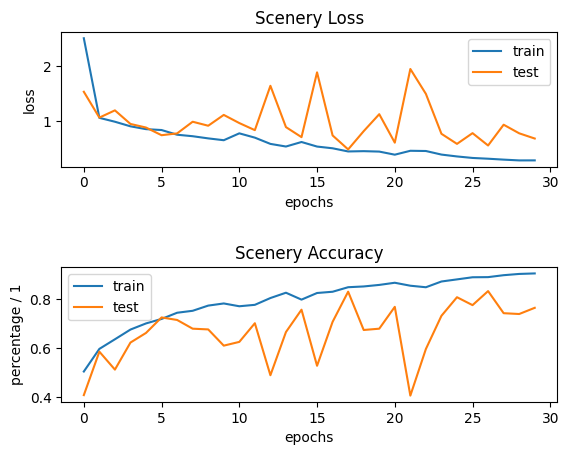

In [ ]:
plt.subplot(212)
plt.title('Scenery Accuracy')
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel("epochs")
plt.ylabel("percentage / 1")
plt.legend()


plt.subplot(211)
plt.title('Scenery Loss')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplots_adjust(hspace = 0.75)

plt.savefig('loss_curve_and_accuracy.png', bbox_inches = 'tight', dpi=300)
plt.show()

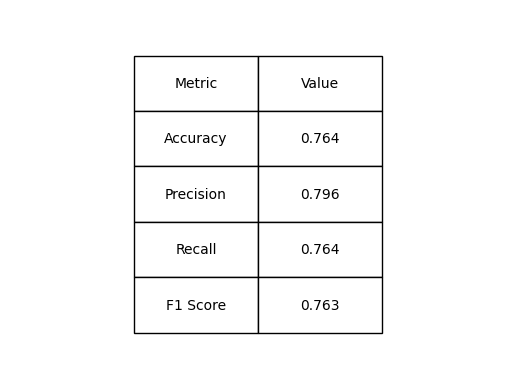

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
label_test_classes = np.argmax(label_test, axis=1)

accuracy = scores[1]
type(accuracy)

precision = precision_score(label_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(label_test_classes, y_pred_classes, average='weighted')
recall = recall_score(label_test_classes, y_pred_classes, average='weighted')

headers = ["Metric", "Value"]
data = [
    
    ["Accuracy", "%.3f" % accuracy],
    ["Precision", "%.3f" % precision],
    ["Recall", "%.3f" % recall],
    ["F1 Score", "%.3f" % f1],
]

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=data, colLabels=headers, cellLoc='center', loc='center')

# Auto-size the columns
for key, cell in table.get_celld().items():
    cell.set_width(0.25)
    cell.set_height(0.15)

# Save the table as a PNG image
plt.savefig('metrics_table.png', bbox_inches='tight', dpi=300)

# Show the table in the notebook (optional)
plt.show()

# Training AlexNet Model on RPS dataset

In [ ]:
image_train2, label_train2, image_test2, label_test2 = fetch_rps()

In [ ]:
# Generate:
# Loss Curve
# Accuracy
# Precision
# F1 Score

In [ ]:
print(image_train2.shape)
print(label_train2.shape)
print(image_test2.shape)
print(label_test2.shape)

(1750, 200, 300, 3)
(1750, 3)
(438, 200, 300, 3)
(438, 3)


In [ ]:
# image_train_rdc = image_train[:4666]
# print(image_train_rdc.shape)
# label_train_rdc = label_train[:4666]
# print(label_train_rdc.shape)

# # Removing the original arrays from memory to have more "System RAM"
# %xdel image_train
# %xdel label_train

In [ ]:
ANM2 = AlexNetModel((200,300,3), 3, 'categorical_crossentropy')

In [ ]:
ANM2.summary()

In [ ]:
history2 = ANM2.fit(image_train2, label_train2,validation_data=(image_test2, label_test2), epochs=30, batch_size=64,verbose=1)

In [ ]:
scores2 = ANM2.evaluate(image_test2, label_test2)
print(scores2)

14/14 [==============================] - 0s 9ms/step - loss: 1.0950 - accuracy: 0.9224
[1.0950114727020264, 0.922374427318573]


In [ ]:
y_pred2 = ANM2.predict(image_test2)

14/14 [==============================] - 0s 9ms/step


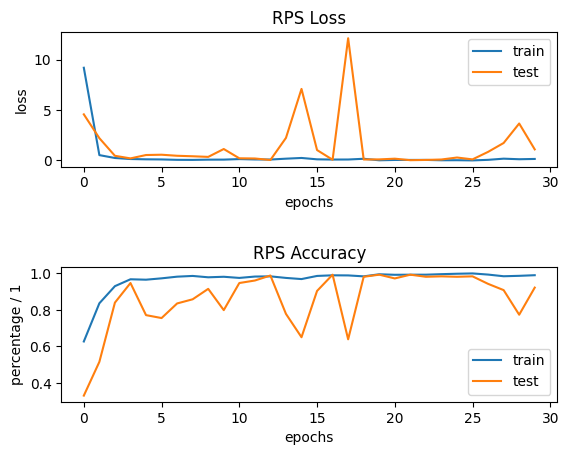

In [ ]:
plt.subplot(212)
plt.title('RPS Accuracy')
plt.plot(history2.history['accuracy'], label = 'train')
plt.plot(history2.history['val_accuracy'], label = 'test')
plt.xlabel("epochs")
plt.ylabel("percentage / 1")
plt.legend()


plt.subplot(211)
plt.title('RPS Loss')
plt.plot(history2.history['loss'], label = 'train')
plt.plot(history2.history['val_loss'], label = 'test')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplots_adjust(hspace = 0.75)

plt.savefig('loss_curve_and_accuracy.png', bbox_inches = 'tight', dpi=300)
plt.show()

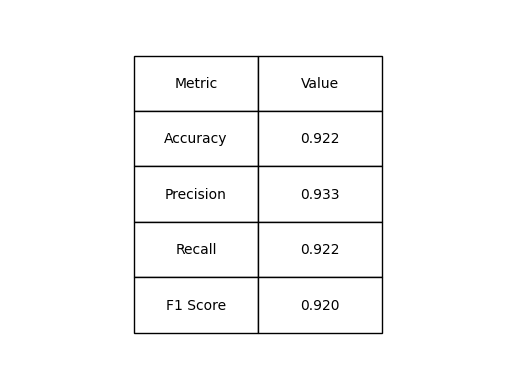

In [ ]:
y_pred_classes2 = np.argmax(y_pred2, axis=1)
label_test_classes2 = np.argmax(label_test2, axis=1)

accuracy2 = scores2[1]
type(accuracy2)

precision2 = precision_score(label_test_classes2, y_pred_classes2, average='weighted')
f12 = f1_score(label_test_classes2, y_pred_classes2, average='weighted')
recall2 = recall_score(label_test_classes2, y_pred_classes2, average='weighted')

headers2 = ["Metric", "Value"]
data2 = [
    
    ["Accuracy", "%.3f" % accuracy2],
    ["Precision", "%.3f" % precision2],
    ["Recall", "%.3f" % recall2],
    ["F1 Score", "%.3f" % f12],
]

fig2, ax2 = plt.subplots()
ax2.axis('tight')
ax2.axis('off')
table2 = ax2.table(cellText=data2, colLabels=headers2, cellLoc='center', loc='center')

# Auto-size the columns
for key, cell in table2.get_celld().items():
    cell.set_width(0.25)
    cell.set_height(0.15)

# Save the table as a PNG image
plt.savefig('metrics_table.png', bbox_inches='tight', dpi=300)

# Show the table in the notebook (optional)
plt.show()

# Training AlexNet Model on Eyes dataset

In [ ]:
image_train3, label_train3, image_test3, label_test3 = fetch_eyes()

In [ ]:
# Generate:
# Loss Curve
# Accuracy
# Precision
# F1 Score

In [ ]:
print(image_train3.shape)
print(label_train3.shape)
print(image_test3.shape)
print(label_test3.shape)

(2467, 224, 224, 3)
(2467, 4)
(433, 224, 224, 3)
(433, 4)


In [ ]:
image_train_rdc = image_train[:4666]
print(image_train_rdc.shape)
label_train_rdc = label_train[:4666]
print(label_train_rdc.shape)

# Removing the original arrays from memory to have more "System RAM"
%xdel image_train
%xdel label_train

In [ ]:
ANM3 = AlexNetModel((224,224,3),4,'categorical_crossentropy')

In [ ]:
ANM3.summary()
# summary gave 33mill parameters, so I adjusted the alexnetmodel() function and increased parameters
# then ran the previous cell again so "ANM3" would have ~40mill parameters

In [ ]:
history3 = ANM3.fit(image_train3, label_train3,validation_data=(image_test3, label_test3), epochs=30, batch_size=64,verbose=1)

Epoch 1/30
39/39 [==============================] - 4s 54ms/step - loss: 6.0191 - accuracy: 0.5857 - val_loss: 107.6664 - val_accuracy: 0.2448
Epoch 2/30
39/39 [==============================] - 1s 25ms/step - loss: 0.9549 - accuracy: 0.7175 - val_loss: 2.3209 - val_accuracy: 0.5035
Epoch 3/30
39/39 [==============================] - 1s 25ms/step - loss: 0.5932 - accuracy: 0.7463 - val_loss: 3.5406 - val_accuracy: 0.3303
Epoch 4/30
39/39 [==============================] - 1s 26ms/step - loss: 0.4907 - accuracy: 0.7540 - val_loss: 1.6340 - val_accuracy: 0.4711
Epoch 5/30
39/39 [==============================] - 1s 26ms/step - loss: 0.3956 - accuracy: 0.7957 - val_loss: 0.7082 - val_accuracy: 0.6420
Epoch 6/30
39/39 [==============================] - 1s 26ms/step - loss: 0.3746 - accuracy: 0.7921 - val_loss: 1.6746 - val_accuracy: 0.5173
Epoch 7/30
39/39 [==============================] - 1s 26ms/step - loss: 0.3380 - accuracy: 0.8099 - val_loss: 0.8433 - val_accuracy: 0.7159
Epoch 8/30


In [ ]:
scores3 = ANM3.evaluate(image_test3, label_test3)
print(scores3)

14/14 [==============================] - 0s 19ms/step - loss: 0.7957 - accuracy: 0.7760
[0.795745849609375, 0.7759815454483032]


In [ ]:
y_pred3 = ANM3.predict(image_test3)

14/14 [==============================] - 0s 8ms/step


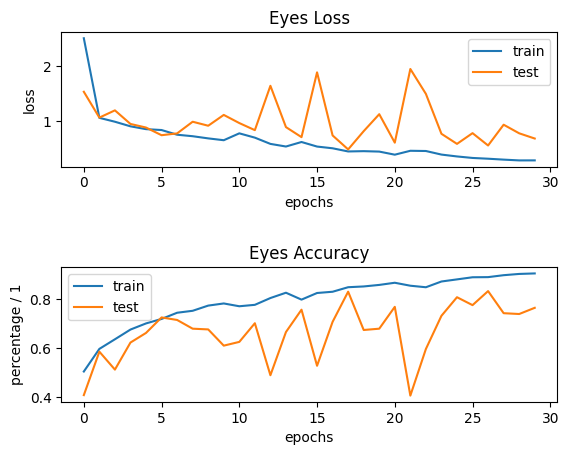

In [ ]:
plt.subplot(212)
plt.title('Eyes Accuracy')
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.xlabel("epochs")
plt.ylabel("percentage / 1")
plt.legend()


plt.subplot(211)
plt.title('Eyes Loss')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplots_adjust(hspace = 0.75)

plt.savefig('loss_curve_and_accuracy.png', bbox_inches = 'tight', dpi=300)
plt.show()

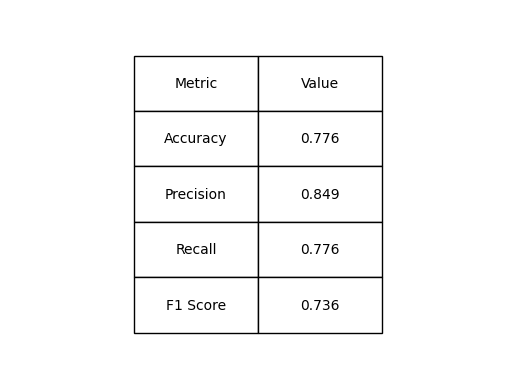

In [ ]:
y_pred_classes3 = np.argmax(y_pred3, axis=1)
label_test_classes3 = np.argmax(label_test3, axis=1)

accuracy3 = scores3[1]
type(accuracy3)

precision3 = precision_score(label_test_classes3, y_pred_classes3, average='weighted')
f13 = f1_score(label_test_classes3, y_pred_classes3, average='weighted')
recall3 = recall_score(label_test_classes3, y_pred_classes3, average='weighted')

headers3 = ["Metric", "Value"]
data3 = [
    ["Accuracy", "%.3f" % accuracy3],
    ["Precision", "%.3f" % precision3],
    ["Recall", "%.3f" % recall3],
    ["F1 Score", "%.3f" % f13],
]

fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table3 = ax.table(cellText=data3, colLabels=headers, cellLoc='center', loc='center')

# Auto-size the columns
for key, cell in table3.get_celld().items():
    cell.set_width(0.25)
    cell.set_height(0.15)

# Save the table as a PNG image
plt.savefig('metrics_table.png', bbox_inches='tight', dpi=300)

# Show the table in the notebook (optional)
plt.show()

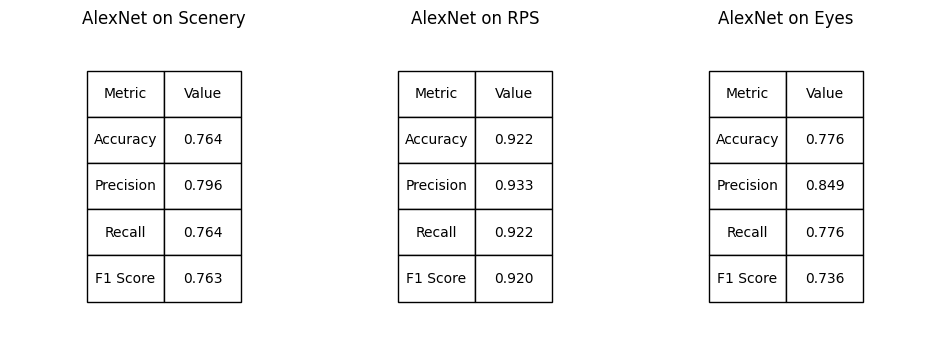

In [ ]:
scenery_metrics = [
   ["Accuracy", "%.3f" % accuracy],
    ["Precision", "%.3f" % precision],
    ["Recall", "%.3f" % recall],
    ["F1 Score", "%.3f" % f1],
]

rps_metrics = [
    ["Accuracy", "%.3f" % accuracy2],
    ["Precision", "%.3f" % precision2],
    ["Recall", "%.3f" % recall2],
    ["F1 Score", "%.3f" % f12],
]

eyes_metrics = [
    ["Accuracy", "%.3f" % accuracy3],
    ["Precision", "%.3f" % precision3],
    ["Recall", "%.3f" % recall3],
    ["F1 Score", "%.3f" % f13],
]

datasets = [scenery_metrics, rps_metrics, eyes_metrics]
dataset_names = ["AlexNet on Scenery", "AlexNet on RPS", "AlexNet on Eyes"]
headers = ["Metric", "Value"]

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
plt.subplots_adjust(wspace=0.01)

for ax, data, name in zip(axes, datasets, dataset_names):
    ax.axis('tight')
    ax.axis('off')
    ax.set_title(name)
    table = ax.table(cellText=data, colLabels=headers, cellLoc='center', loc='center')
    
    # Auto-size the columns
    for key, cell in table.get_celld().items():
        cell.set_width(0.25)
        cell.set_height(0.15)

# Save the tables as a PNG image
plt.savefig('metrics_tables.png', bbox_inches='tight', dpi=300)

# Show the tables in the notebook (optional)
plt.show()